In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qcoptim import cost
from qcoptim import ansatz as anz
from qcoptim import utilities as ut
from qcoptim import optimisers as op

pi = np.pi

## Basic cost and ansatz construction 

* Ansatz class has useful properties that are used by cost class
* Cost class has an ansatz, and knows required measurement settings required to evaluate the cost

RandomAnsatz(4, 1) returns 4 qubits 1 layer of with random x, y and z gates 

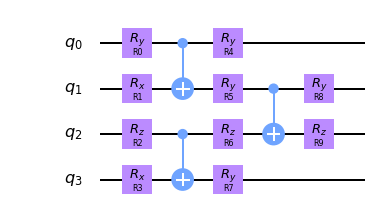

In [2]:
random_ansatz = anz.RandomAnsatz(4, 1)
instance = ut.quick_instance() # qiskit simulator
random_ansatz.circuit.draw(output='mpl')

## Setting up cost functions
* Based around cost object that: 
    * handle required measurement settings
    * know to to compile measurement circuits
    * know how to evaluate the cost function from a qiskit results object
   
`cost` module has a lot of random cost functions, mostly just need an ansatz and instance and they're ready to go

**This ansatz circuit is clearly not the best for the problem at hand, just an example for here**

this cost function is called circuit_2sqt2

 Required measurement settings are:
['xzyx', 'xzxx', 'yzxx', 'yyzx', 'yxzx', 'xyxy', 'xzyy', 'yzzx', 'yxyx', 'yyxx', 'yyyx', 'yxxx', 'yzzy', 'xxzy', 'yzyx', 'zxxz', 'zyyz', 'xzzx', 'zzzz']
which have already been compiled using the provided instance

 there are 19 parameterised measurement circuits one for each measurement setting: e.g.


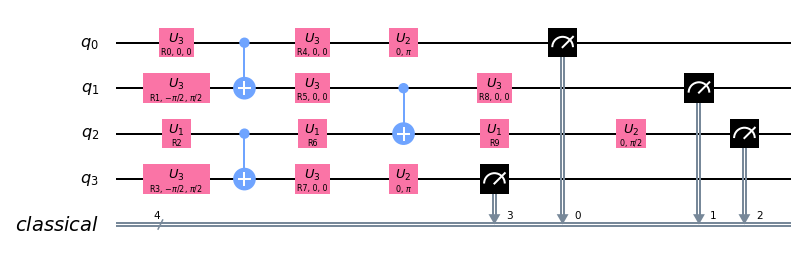

In [3]:
atoms = 'H 0 0 0; H 0 0 1; H 0 0 2' # Three H atoms located at x = 0,1,2 respectively
cst = cost.Chemistry_Cost(atoms, random_ansatz, instance, verbose=False)

print('this cost function is called ' + cst.name)

print('\n Required measurement settings are:')
print(cst._list_meas)
print('which have already been compiled using the provided instance')

print('\n there are {} parameterised measurement circuits one for each measurement setting: e.g.'.format(len(cst.meas_circuits)))
cst.meas_circuits[0].draw(output='mpl')

## Evaluating cost functions
* Can bind parameters independently or eval direction
* Can use this as single cost evaluation in GPyOpt, or any other optim method.

In [4]:
# Long way 

param_point = np.random.rand(cst.nb_params)
circs = cst.bind_params_to_meas(param_point)
result = instance.execute(circs)
print(cst.evaluate_cost(result))

# OR short way

print(cst(param_point)) # Is difference because of the shotnoise

# Supports vectorisation 
print('\n Vectorised')
print(cst([param_point, 2*param_point])) 

-0.32387844075558203
[[-0.3077882]]

 Vectorised
[[-0.28028811]
 [-0.65006055]]


## Construct a list of related cost function
E.g. find a potential energy surface for 3 H atoms 

All using the same ansatz circuit and quantum instance

The all have the same ansatz and so can evaluate each others results, but need to specify the name (used to allow multiple submissions on the same qiskit result)

In [5]:
Deltas = np.linspace(0.1, 1, 4)
H_coords_vec = ['; '.join(['H 0 0 {}'.format(d) for d in [0, dd, 2*dd]]) for dd in Deltas]

for ct, H in enumerate(H_coords_vec):
    print('config ' + str(ct) + ': ' +H)

# create a cost function for each distance
cost_vec = [cost.Chemistry_Cost(H, random_ansatz, instance) for H in H_coords_vec]


param_point = np.random.rand(cst.nb_params)
cost_calc = cost_vec[0] # the function to bind params
circs = cost_calc.bind_params_to_meas(param_point) # only using the first circ to get results object
result = instance.execute(circs)

for ct, cs in enumerate(cost_vec):
    print('\n  cost vec ' + str(ct) + ' evaluated to ')
    print(cs.evaluate_cost(result, name = cost_calc.name)) # By default evaluate_cost will only work if that object submitted the circuits

# e.g. cost_vec[-1].evaluate_cost(result) will error because cost_vec[-1] request any circuits in the results object

config 0: H 0 0 0; H 0 0 0.1; H 0 0 0.2
config 1: H 0 0 0; H 0 0 0.4; H 0 0 0.8
config 2: H 0 0 0; H 0 0 0.7; H 0 0 1.4
config 3: H 0 0 0; H 0 0 1.0; H 0 0 2.0

  cost vec 0 evaluated to 
28.210478838762228

  cost vec 1 evaluated to 
5.646544417705741

  cost vec 2 evaluated to 
1.412103207305734

  cost vec 3 evaluated to 
-0.38758782226106114


## Parallelised BO's with info sharing
Now we have coordinate parametrised cost functions, can run shared BO
* Use `ParallelRunner` in the optimisers module (this is still clunky)
* BO settings must be constructed
* Can use ut.gen_default_argsbo as a first guess (these are the args for GPyOpt's method)

Valid strings for sharing in `ParallelRunner` are `method = ...`
* `'shared'` (all to all), 
* `'independent'` (no sharing - may as well run separate BOs - but there is a speed up for job submission) 
* `'NN1'` (nearest neighbour sharing `'NN2, NN3, NNn'` also works for some int n) 
* `'left/right'` (only shares in one directions)
* `'2d1.232'` (etc. for 2d lattices, shares if distance between grid (assumed square) points is less than the float after 2d (here < 1.232))

the ParallelRunner handles all circuit generation/bo sharing parts e.g. 

`runner.next_evaluation_circuits()` chooses which BO points from each optimiser to evaluate next (including init points)

`runner.init_optimisers()` inits all BOs (need to call only once after results are obtained from a backend (see below))

`runner.update()` updates all BO's from (including all cross evaluations of cost functions evaluated from an internal results object (see below))

In [6]:
domain = np.array([(0, 2*pi) for i in range(cst.nb_params)])
bo_args = ut.gen_default_argsbo(f=cst,
                                domain=domain,
                                nb_init=10,
                                eval_init=False)
bo_args['nb_iter'] = 20 # Only acutally used in GPyOpt - not in the following 


runner = op.ParallelRunner(cost_vec, # all cost objects are running together
                           op.MethodBO, # Use BO optimiser (only one for now)
                           optimizer_args = bo_args, # could pass a list of seperate args to each bo
                           share_init = True, # Share init points
                           method = 'shared') # Share iter points

print('runner has {} BO objects with parameters give in bo_args- one for each cost function \n'.format(len(runner.optim_list)))

runner.next_evaluation_circuits() # get params
print('There are now {} circuits ready to be send to a backend'.format(len(runner.circs_to_exec)))
print('These are from {} different settigns per point, and {} different init points'.format(len(runner.cost_objs[0]._list_meas), bo_args['initial_design_numdata'] )  )
print("As the inits are shared all BO's see this data. for share_init = False, there would be 4x more circs (19 meas settings, 10 points for each cost func)")

runner has 4 BO objects with parameters give in bo_args- one for each cost function 

There are now 190 circuits ready to be send to a backend
These are from 19 different settigns per point, and 10 different init points
As the inits are shared all BO's see this data. for share_init = False, there would be 4x more circs (19 meas settings, 10 points for each cost func)


## Job submission
Because it's time consuming to submit jobs independently the jub submission is passed to a Batch object. This allows multiple parallel optims to be run in parallel themselves.

For a single runner `Bat.submit_exec_res(runner)` submits all `runner.circs_to_exec` to a backend as one job and will put the results object back in runner. It's equivalent to 

`res = instance.execute(runner.circs_to_exec)` 

`runner._last_results_obj = res` (this is res object that the cost functions are use evaluated on) 

For multiple runners `r1, r2` and `r3`, `Bat.submit(r1); Bat.submit(r2); Bat.submit(r3); Bat.execute()` sends all circs from `r1,r2,r3` as a single job. And the runner can get their part of the object by `Bat.results(r1)` etc (note there is a bug for using auto measurement error correction)

At the moment we still don't have the following in the loop, but lets you chance the state of the BO's at each stage 

In [7]:
Bat = ut.Batch(instance)

# Init runner object 
runner = op.ParallelRunner(cost_vec, 
                           op.MethodBO, 
                           optimizer_args = bo_args,
                           share_init = True, 
                           method = 'shared')

# Get next parameters (chosen by BO)
runner.next_evaluation_circuits()

# Simulate circuits and init the optimisers
Bat.submit_exec_res(runner)
runner.init_optimisers()

# Run 5 iterations of BO
for ii in range(5):
    runner.next_evaluation_circuits() # BOs choose next points and bind params to circs
    Bat.submit_exec_res(runner) # run the circs to get the objects
    runner.update() # update the optimizers
    print(ii)

0
1
2
3
4


## Getting results
Each GPyOpt BO method is in the runner

Have direct acces to these, or can interact with the runner itsself

[[26.9106002]]
[[4.4515623]]
[[0.58016104]]
[[-1.00989265]]
configuration:  H 0 0 0; H 0 0 0.1; H 0 0 0.2   has energy  [[26.9106002]]
configuration:  H 0 0 0; H 0 0 0.4; H 0 0 0.8   has energy  [[4.4515623]]
configuration:  H 0 0 0; H 0 0 0.7; H 0 0 1.4   has energy  [[0.58016104]]
configuration:  H 0 0 0; H 0 0 1.0; H 0 0 2.0   has energy  [[-1.00989265]]


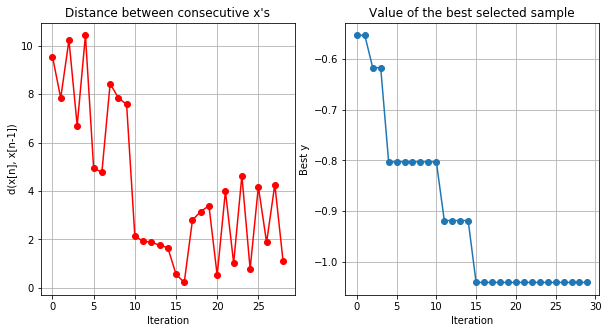

In [8]:
optim_list = runner.optim_list

# Best parameter point for eeach cost function 
x_opt_pred = [opt.best_x for opt in runner.optim_list]

# Get a potential energy curve
energy = [c(x) for c, x in zip(runner.cost_objs, x_opt_pred)]

for h, e in zip(H_coords_vec, energy):
    print('configuration:  ' + h + '   has energy  ' +  str(e))
    
# BO optimizers as GPyOpt objects
gpy_bo = [o.optimiser for o in optim_list]
[bo.run_optimization(max_iter = 0, eps = 0) for bo in gpy_bo] # needed for final upaate of internal state
gpy_bo[-1].plot_convergence()

Text(0.5, 1.0, '5 step optimisation')

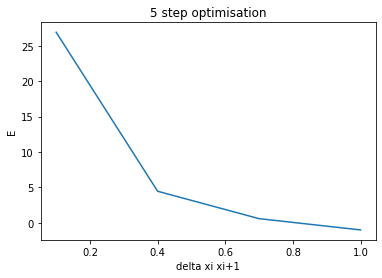

In [9]:
plt.plot(Deltas, np.squeeze(energy))
plt.xlabel('delta xi xi+1')
plt.ylabel('E')
plt.title('5 step optimisation')